# GPT-2's Thoughts on Your Relationship - Capstone Three
### By Robert Malka (With thanks to Benjamin Bell & Dipanjan Sarkar!)

#### An Introduction

With this capstone, I am using GPT-2 to give relationship advice to anyone who needs it. The way I'll do this is by feeding reddit data (r/relationship_advice) to GPT-2. 

In order to do this effectively, I am separating the work into two notebooks. This first notebook does the following:

- Explores PRAW & PSAW to scrape data from r/relationship_advice
- Cleans the data and separates titles & comments into separate datasets to run through GPT-2 (see https://towardsdatascience.com/how-to-fine-tune-gpt-2-so-you-can-generate-long-form-creative-writing-7a5ae1314a61 and https://minimaxir.com/2019/09/howto-gpt2/ for an understanding of what I did to make this work). 
- Takes the titles & comments as a single dataset and runs them through an EDA so we can get a sense of the kind of problems people go through, the kind of advice given from top comments, and any other interesting details we find noteworthy.

A second Google Colab notebook is what I'm using to fine-tune GPT-2 and derive answers. That notebook can be found here: https://colab.research.google.com/drive/1lBe1EwhCrttiZzfarOe-ofaTp5d-6-Ca#scrollTo=AaSVtgiKp0yW

Finally, I'm taking this already-trained model and making it available to everyone through a simple website, which is forthcoming.

Submit feedback and your thoughts to me anytime, at robert@malkarobert.com.

#### Scraping r/relationship_advice

Here, I run through PRAW (acronym for Python Reddit API Wrapper). While it's a great help, I'm only able to pull 1,000 requests using PRAW. Doing it here for mostly-ceremonial purposes. 

To get around this roadblock, since we need lots of data to render GPT-2 effective, we have to use PSAW (Python Pushshift.io API Wrapper), which lets us pull many more requests. (Our goal is ~1MM titles & 2MM+ top comments.) 

We will run an EDA on a segmented portion of the titles & comments later, but for now let's get this scraping done!

In [324]:
#Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv 
import datetime as dt

#For scraping Reddit
import praw
from psaw import PushshiftAPI

#For EDA
import re
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.decomposition
import matplotlib.colors
from textblob import TextBlob
from gensim.models import Word2Vec
import nltk
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import textstat
import gensim.corpora as corpora
from pprint import pprint
import gensim
from gensim.utils import simple_preprocess
import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os

#### Part I: PRAW

In [356]:
#Credentials to pull PRAW data. Removed in final version, though info to add your own credentials is here:
#https://towardsdatascience.com/scraping-reddit-data-1c0af3040768

reddit = praw.Reddit(client_id="O8R1VcL1VrHjPw",
                     client_secret="0rvMvHsQN8JlumHSRwFU2O-mkq1UBw",
                     password="kVQVQVzwWqsk2Cq",
                     user_agent="relationship_advice script by u/fbirobby",
                     username="fbirobby",
                     check_for_async=False)

In [357]:
#In final version: use async PRAW to get around all the messages being pulled below - renders the notebook 
#unreadable.

posts = []

rel_advice_subreddit = reddit.subreddit('relationship_advice')

def return_10_best_comments(submission):
    # Set comment sort to best before retrieving comments
    submission.comment_sort = 'best'
    # Limit to, at most, 10 top level comments
    submission.comment_limit = 10
    top_10_comments = []
    # Fetch the comments and print each comment body
    for top_level_comment in submission.comments:
        if isinstance(top_level_comment, praw.models.MoreComments):
            continue
        top_10_comments.append(top_level_comment.body)
        # Here you can fetch data off the comment.
        # For the sake of example, we're just printing the comment body.
    return top_10_comments


for post in rel_advice_subreddit.hot(limit=1000):
    posts.append({'title': post.title, 'id' : post.id, 'num_comments':post.num_comments, 
                  'body':post.selftext, 'created':post.created, 'comments':return_10_best_comments(post)})

df_PRAW = pd.DataFrame(posts)


In [58]:
df_PRAW.head()

,title,id,num_comments,body,created,comments
0,[meta] ThrowRA accounts moving forward (tl;dr:...,j6q2q1,1,**What:** All posts will have karma and commen...,1.602103e+09,"[if you made it this far, here's some Bonus Co..."
1,[meta] auto-removing moral judgment threads. a...,ivahe5,0,Previously we'd been [issuing 1 day bans](http...,1.600479e+09,[]
2,How do I(F26) explain to my boyfriend (M29) th...,lkg8dh,94,My partner and I have been dating for 3 years....,1.613433e+09,[He’s got issues and needs to see a doctor and...
3,My dad has left his wife because she hates me ...,lkks36,72,"Hey, I'm really struggling right now and need ...",1.613445e+09,"[She obviously made a stupid ultimatum, and yo..."
4,I (23 F) really like my coworkers. I like taki...,lkdbh7,103,I am a single mom to twin five year old boy gi...,1.613423e+09,[When I was a first year teacher I had zero mo...


In [ ]:
#Need to put here the add string with start text & end text (the encoding). Then this is done :) 

In [89]:
#Less than 1k rows, as expected - not nearly enough to produce good content from GPT-2. On to Pushshift!

df_PRAW.shape

(902, 6)

In [88]:
#We see here that multiple comments are fitted into a list! So now we can run this tiny sample through
#GPT-2 as we please. Note that you'll want to generate in bulk from GPT-2 many, many times to get a few good samples.
df_PRAW['comments'][2]

['He’s got issues and needs to see a doctor and therapist. This is such obvious mental health stuff. And it can be helped IF he wants to get help. \n\nI can appreciate that you’ve given it a good shot but I think that if I were in your shoes, I’d tell him one last time that he needs to get help and make some changes or you’re out. Or just tell him that you’d like a 3-6 mo break to give him time to focus on his health and then you can revisit. \n\nYou can’t fix this—it’s not your issue to fix. I’m sorry.',
 'What you see is what you get.  You can\'t "explain" this to him - he\'s not going to change his behavior if something doesn\'t force him to.',
 "If he's not a catch, it's time to release him.",
 'If you ever live with this guy, one of the following is likely to happen:\n\n1) You are going to live in a pigsty\n\n2) Your home will be clean, but you do all the housework \n\n3) Your home will be clean, and you share responsibility for the housework, but you will be in charge of keeping 

#### Part II: Pushshift.io

In [113]:
#Thanks to dmarx for the clear code on pulling from PSAW! PSAW docs are surprisingly unclear.
#https://github.com/dmarx/psaw

api = PushshiftAPI()

#Start date we're beginning to pull posts from
start_epoch=int(dt.datetime(2017, 1, 1).timestamp())


#Pulling submissions from relationship_advice (both the title and body of a post)

gen_sub = list(api.search_submissions(after=start_epoch,
                            subreddit='relationship_advice',
                            filter=['title', 'selftext', 'id'],
                            limit=1000000))


#Converting to dataframe
dfsub = pd.DataFrame([thing.d_ for thing in gen_sub])


#In the event we want to pull our psaw data directly into a CSV, this is the code to do it for the comments.
#Thanks to Jack465 for the help! https://gist.github.com/Jack465/b27b9c2d627e24f25a74145520d1b0d1

#with open('reddit_relationships.csv', 'w', newline='', encoding="utf-8") as csvfile:
#    writerobj = csv.writer(csvfile, delimiter=',',quotechar='|', quoting=csv.QUOTE_MINIMAL)
#    for comment in gen:
#        writerobj.writerow([comment.id, comment.score, comment.body])

C:\Users\Robert Malka\Anaconda3\lib\site-packages\psaw\PushshiftAPI.py:192: UserWarning: Got non 200 code 502
  warnings.warn("Got non 200 code %s" % response.status_code)
C:\Users\Robert Malka\Anaconda3\lib\site-packages\psaw\PushshiftAPI.py:180: UserWarning: Unable to connect to pushshift.io. Retrying after backoff.
  warnings.warn("Unable to connect to pushshift.io. Retrying after backoff.")


In [ ]:
#Pulling comments from relationship_advice

gen_com = api.search_comments(after=start_epoch,
                            subreddit='relationship_advice',
                            filter=['body', 'link_id', 'id', 'score'],
                            limit=35000000)

dfcom = pd.DataFrame([thing.d_ for thing in gen_com])

In [364]:
dfcom.sort_values(by=['score'])

,body,created_utc,id,link_id,score,created
586274,Don’t ask her. Jeez. Just start being a bit to...,1610825460,gjhtpjw,t3_kylt66,-983,1.610854e+09
3531446,"I mean, you could be a good wife and suck it up?",1599953630,g500fcx,t3_irmzxf,-849,1.599982e+09
1852995,Age gap only important when is the man. If its...,1605997214,gd4bc9u,t3_jyjcw7,-793,1.606026e+09
203550,"Yup! \n\nAnd don't forget, it's just as okay ...",1612983357,gmuiyrv,t3_lgufij,-635,1.613012e+09
3346834,[removed],1600466247,g5qyjpc,t3_ivdleq,-621,1.600495e+09
...,...,...,...,...,...,...
3438124,[removed],1600205660,g5em5yz,t3_itgucp,15799,1.600234e+09
3301943,Start checking pawn shops for the first two ri...,1600612470,g5zfr1c,t3_iweaes,20203,1.600641e+09
3450533,"Go to a doctor, get tested for sterility, and ...",1600181129,g5cz3tm,t3_ita3mx,20783,1.600210e+09
3447257,1. Get tested to see if you are sterile \n2. ...,1600187375,g5ddl0p,t3_ita3mx,24323,1.600216e+09


In [115]:
#To save the raw files so I don't have to pull them multiple times

dfsub.to_csv("dfsub_raw.csv", index=False)
dfcom.to_csv("dfcom_raw.csv", index=False)

#### Part III: Basic Cleaning

#### Data Fields

For dfsub (the submissions dataset), the following fields were pulled:

- id: The unique post ID
- created: The timestamp of the post in datetime (originally in epoch time)
- title: The subject line of the post
- post_body: The full body of the post

For dfcom (the comments dataset), the following fields were pulled:

- link_id: The unique id of the post the comment belongs to, with "t3_" indicating that it is a comment and the remainder of the id the same as the post id.
- id: The unique comment id.
- created: The timestamp of the comment in datetime (originally in epoch time)
- body: The full body of the comment.

For a future dataset, I will also be pulling:
- score: The number of "upvotes" the community gave to that post (roughly, how much interest the community had in that post)

This is so I can evaluate the best comments given.


I joined these dataframes together into one, df_fin, emphasizing only:

- id: The unique post ID
- created: The timestamp of the post in datetime (originally in epoch time)
- title: The subject line of the post
- post_body: The full body of the post
- comment_body: The full body of the comment.

On to cleaning!

In [116]:
#The submissions dataset

#1) convert epoch time to datetime 
dfsub['created'] = pd.to_datetime(dfsub['created'], unit='s')
#2) delete the 'created_utc' column
dfsub = dfsub.drop('created_utc', axis=1)
#3) rename 'selftext' to 'post_body'
dfsub = dfsub.rename(columns={'selftext': 'post_body'})

In [118]:
#making the title & post_body lowercase for future processing.

dfsub['title'] = dfsub['title'].apply(lambda x: x.lower())
dfsub['post_body'] = dfsub['post_body'].astype(str)
dfsub['post_body'] = dfsub['post_body'].apply(lambda x: x.lower())

In [124]:
dfsub.head()

,id,post_body,title,created
0,lleqbz,my boyfriend broke up with me (we are both 14 ...,help!!,2021-02-17 05:57:06
1,llepeq,let me start with i (29m) love my so (28f) and...,so opened up about their mental health,2021-02-17 05:55:53
2,lleoga,"i’m not currently in a relationship, but have ...",36 (m) divorced dad needs advice on how to sta...,2021-02-17 05:54:32
3,lleoe1,im feeling so worthless..weather its potting a...,husband say i dnt ever put in 100% even when i...,2021-02-17 05:54:28
4,llen67,sorry in prior for any grammatical mistake. th...,i(19m) want to help my girlfriend(20f) but don...,2021-02-17 05:52:46


In [365]:
#The same cleaning for the comments dataset.

dfcom['created'] = pd.to_datetime(dfcom['created'], unit='s')
dfcom = dfcom.drop('created_utc', axis=1)

In [366]:
#Making the comments lowercase for future processing.

dfcom['body'] = dfcom['body'].apply(lambda x: x.lower())

In [374]:
dfcom = dfcom.sort_values(by=['score'])

In [377]:
dfcom_score = dfcom[dfcom['score'] > 9]  

In [378]:
dfcom_score.shape

(167524, 5)

In [385]:
dfsub.head()

,id,post_body,title,created
0,t3_lleqbz,my boyfriend broke up with me (we are both 14 ...,help!!,2021-02-17 05:57:06
1,t3_llepeq,let me start with i (29m) love my so (28f) and...,so opened up about their mental health,2021-02-17 05:55:53
2,t3_lleoga,"i’m not currently in a relationship, but have ...",36 (m) divorced dad needs advice on how to sta...,2021-02-17 05:54:32
3,t3_lleoe1,im feeling so worthless..weather its potting a...,husband say i dnt ever put in 100% even when i...,2021-02-17 05:54:28
4,t3_llen67,sorry in prior for any grammatical mistake. th...,i(19m) want to help my girlfriend(20f) but don...,2021-02-17 05:52:46


In [386]:
dfcom.head()

,body,id,link_id,score,created
586274,don’t ask her. jeez. just start being a bit to...,gjhtpjw,t3_kylt66,-983,2021-01-17 03:31:00
3531446,"i mean, you could be a good wife and suck it up?",g500fcx,t3_irmzxf,-849,2020-09-13 07:33:50
1852995,age gap only important when is the man. if its...,gd4bc9u,t3_jyjcw7,-793,2020-11-22 06:20:14
203550,"yup! \n\nand don't forget, it's just as okay ...",gmuiyrv,t3_lgufij,-635,2021-02-11 02:55:57
3346834,[removed],g5qyjpc,t3_ivdleq,-621,2020-09-19 05:57:27


In [384]:
#Putting all comments from the same thread into a single row.
dfcom_grouped = dfcom_score.groupby('link_id').agg({'body': '\n'.join})
#Checking to see how large the dataset is after the joining.
dfcom_grouped.shape
#Wow! Only 227k entries.

(17686, 1)

In [387]:
dfcom_grouped.head()

,body
link_id,
t3_goqc5q,from your child. that’s messed up.\nshe’s your...
t3_gpojb8,dude op sounds like a badass. he justs deflect...
t3_gu2ykj,that's not a good reason to stay. call the pol...
t3_hitc7k,peak reddit comment here
t3_hre0pw,"i'm going to assume that when you say ""love an..."


In [131]:
#testing to see if the submissions and the comments fit together. (Warning, NSFW.)
dfsub.loc[dfsub.id == "llei6f", "post_body"].to_list()

['about a month ago, my boyfriend of eight months made a comment about how he finds all redheads extremely attractive. i, with brown hair, tried not to let this bother me. however, a few days later when we were going to watch porn together, he was only pulling up videos with girls with red hair. this is when it really started to hurt me. i already have low self esteem to begin with (not his fault at all) but since then, i can barely stand to look at myself in the mirror because i feel like i’m not what he wants. i’ve told him this and he’s apologized profusely and said he wasn’t trying to hurt me and he hates that he did and it was a moment of immaturity and stupidity but i can’t shake it. it’s been over a month and it still hurts just as much as the first day. i don’t know what to do to get over it. we have stopped watching porn together since then and he said that he stopped watching it on his own but i feel like he’s only telling me that to make me feel better. it feels like he does

In [128]:
#they do! This comment visibly responds to the submission above. (Warning, NSFW.)

dfcom.loc[dfcom.link_id=='t3_llei6f', 'body'].to_list()

['honestly, it sounds like he\'s messed this up too much for it to continue. if you\'re carrying his comment with you even after an apology, this really can\'t work as long as you hold onto it. so if you want it to work, you need to recognize that he\'s a moron with a fetish which isn\'t reflective of you who made the mistake of vocalizing his fetish like an idiot, and then you need to decide if you\'re really capable of forgiving him for it and finding your own self esteem again. he put both feet in his mouth and now you just have to decide if you still want to kiss him after he pulls them out and brushes his teeth. no wrong answers - if this relationship is dead there\'s no doubt that he\'s the one that killed it and maybe he\'ll learn to watch his mouth better next time.\n\nto be fair, he actually didn\'t say anything about you, he just said he likes red hair on people. i\'m sure there\'s some feature that you like in men that he doesn\'t have and i\'m also sure that it doesn\'t rea

In [388]:
#t3_ is reddit's indication that these are comments, so adding it to submissions before making df_fin.

#dfsub['id'] = 't3_' + dfsub['id'].astype(str)
df_fin = dfsub.set_index('id').join(dfcom_grouped)
df_fin.head()

,post_body,title,created,body
id,,,,
t3_lleqbz,my boyfriend broke up with me (we are both 14 ...,help!!,2021-02-17 05:57:06,NaN
t3_llepeq,let me start with i (29m) love my so (28f) and...,so opened up about their mental health,2021-02-17 05:55:53,NaN
t3_lleoga,"i’m not currently in a relationship, but have ...",36 (m) divorced dad needs advice on how to sta...,2021-02-17 05:54:32,NaN
t3_lleoe1,im feeling so worthless..weather its potting a...,husband say i dnt ever put in 100% even when i...,2021-02-17 05:54:28,NaN
t3_llen67,sorry in prior for any grammatical mistake. th...,i(19m) want to help my girlfriend(20f) but don...,2021-02-17 05:52:46,NaN


In [389]:
#Dropping all posts for which there were no comments (likely also because 3MM comments wasn't enough to 
#reach all of the comments for all of the posts I pulled (1MM).)

df_fin = df_fin.dropna()

In [390]:
#Checking to see that there are no NaNs

df_fin.isnull().sum().sum

<bound method Series.sum of post_body    0
title        0
created      0
body         0
dtype: int64>

In [391]:
#renaming 'body' for clarity

df_fin = df_fin.rename(columns={'body': 'comment_body'})

In [392]:
#after dropping NaNs, the shape of the dataset is smaller -- ~185k rows. 

df_fin.shape

(14855, 4)

In [373]:
df_fin.to_csv("df_fin_raw.csv", index=False)

In [394]:
#adding encoding for GPT to recognize the start of the text, the prompt ([WP]), followed by the comment
#[RESPONSE], and the end of the text. I'm combining the two into one column so it can more easily be 
#assimilated into a .txt file.

df_fin['title'] = '<|startoftext|>[WP]' + df_fin['title'].astype(str)

In [395]:
df_fin['comment_body'] = ' [RESPONSE]' + df_fin['comment_body'].astype(str) + '<|endoftext|>'

In [396]:
#to make it all one column, for a .txt file for GPT-2 to process.

df_fin['final_GPT2'] = df_fin[['title', 'comment_body']].agg(' '.join, axis='columns')

In [393]:
#And let's verify that we've got it right!

df_fin.head()

,post_body,title,created,comment_body
id,,,,
t3_lk59aq,"so as the title reads, basically my world just...",i (30f) just found out that my fiancé's (32m) ...,2021-02-15 12:04:53,you assumed he was married but you didn't care...
t3_lk4rtz,in march we will hit our 1 year mark. i love h...,my (20f) partner (26f) says it’s a deal breake...,2021-02-15 11:37:07,"from the sounds of it, you may be asexual. and..."
t3_lk4cmz,"hey reddit, \n\ni just want to start with some...",my bf (m22) says he's having thoughts of suici...,2021-02-15 11:13:33,you should tell his family and/or call in a we...
t3_lk489i,i(32m) stumbled into my first relationship thi...,new girlfriend wants me to remove photo of dec...,2021-02-15 11:06:44,"keep the photo, but ditch the new girlfriend i..."
t3_lk475b,i have been in a relationship for 6 months now...,my dad kissed me,2021-02-15 11:04:50,please remove yourself from this situation.\nt...


In [397]:
#Take the final_GPT2 column and make it a dataframe - this is the full size dataframe

df_GPT2_fin = df_fin[['final_GPT2']].copy()

In [399]:
#take a smaller sample of it, since Google Colab can't handle the full-sized dataframe

#df_GPT2_fin2 = df_fin[['final_GPT2']].copy().sample(n=80000)

In [402]:
#.csv file to convert to .txt

df_GPT2_fin.to_csv("GPT-2-data_smaller.csv", index=False)

In [403]:
#conversion to .txt - and we're done!

with open('GPT-2-data_smaller.csv', 'r', encoding="utf8") as inp, open('GPT-2-data_smaller.txt', 'w', encoding='utf-8') as out:
    for line in inp:
        line = line.replace(',', ':')
        out.write(line)

#### Part IV: EDA

Well, we're not going to examine the full dataset, running the code would take way too long. So we'll sample the datasets and play around with them. ~80k of each!

In [146]:
#Checking out the earlier datasets rather than df_fin, and keeping them separate.

dfsub_samp = dfsub.sample(n=80000)
dfcom_samp = dfcom_grouped.sample(n=80000)

In [327]:
dfcom_wordcloud_samp = dfcom_samp.sample(n=10000)

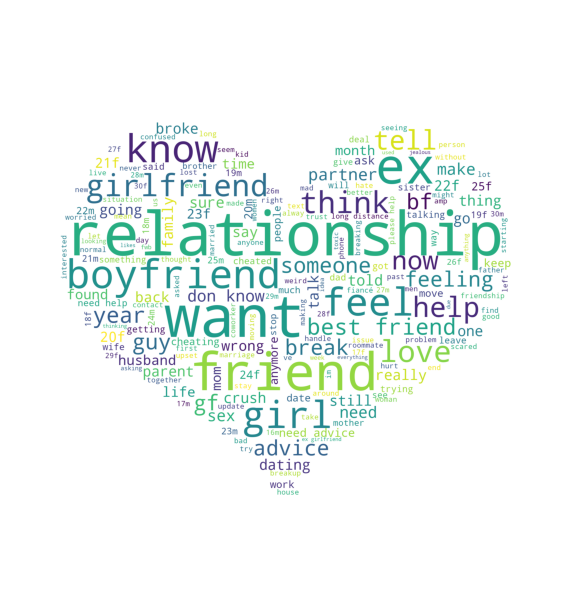

In [326]:
#Let's do Wordclouds for both sample datasets.

#Checking out the post titles in the submissions dataset...

comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in dfsub_samp.title: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  

pic = plt.imread(r"C:\Users\Robert Malka\Desktop\heart.JPEG")


wordcloud = WordCloud(mask = pic, width = 1000, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

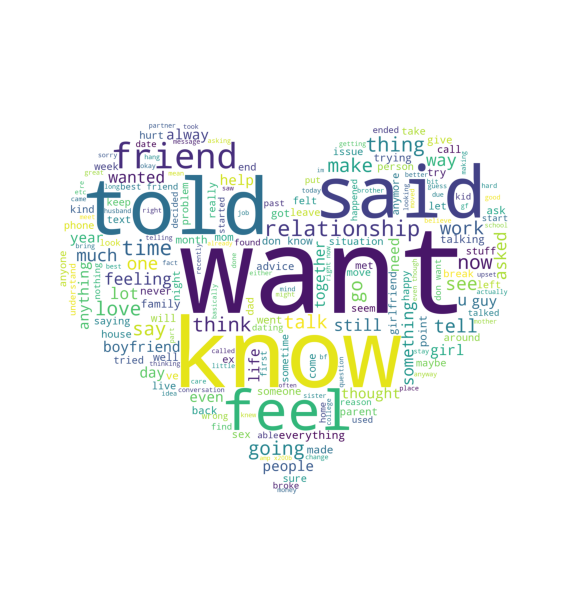

In [329]:
#...& the post_body in the submissions dataset.

comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in dfsub_samp.post_body: 
      
    val = str(val) 
  
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  

pic = plt.imread(r"C:\Users\Robert Malka\Desktop\heart.JPEG")

wordcloud = WordCloud(mask = pic, width = 1000, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)

  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

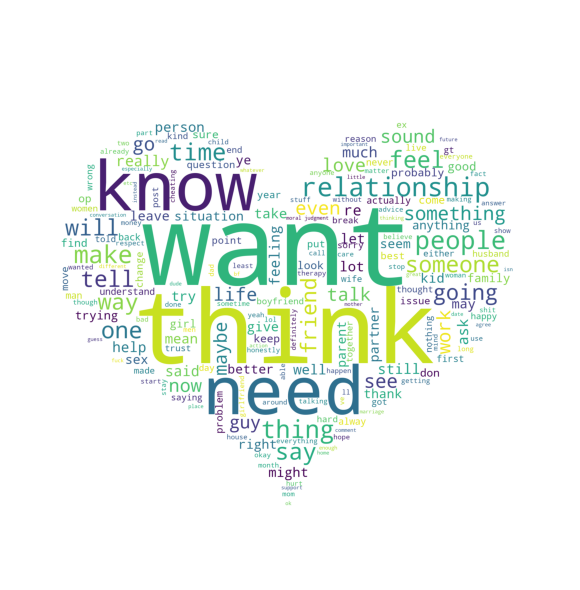

In [328]:
#& lastly the comments in the comments dataset.
#masking function to make wordclouds hearts

comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in dfcom_wordcloud_samp.body: 
      
    val = str(val) 
  
    tokens = val.split() 
      
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  

pic = plt.imread(r"C:\Users\Robert Malka\Desktop\heart.JPEG")

wordcloud = WordCloud(mask = pic, width = 1000, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)


plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

Notice especially the wordcloud about titles, where we see almost everything relates to romantic relationships, and the issues surrounding that. Also notable how many of the men and women asking for advice are young, e.g. 22f, 25m, and so on.

The wordcloud in the post_body notably has verbs in the past tense -- no surprise there, a story is being told. Verbs in the comments wordcloud are present and future tense -- advice-giving, and reassurance about the future. And it's verbs that have the particular prominence in both.

Next, let's look at the polarity of the titles and comments using Textblob, to get a sense of the kind of seriousness and tone we get in r/relationship_advice (I have previously experimented with using Vader, so we'll see the results of TextBlob):

In [262]:
dfsub_samp['polarity'] = dfsub_samp['title'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [263]:
#sort to find by highest and lowest values in polarity.

dfsub_samp.sort_values(by=['polarity'], inplace=True)
dfcom_samp.sort_values(by=['polarity'], inplace=True)

Text(0.5, 1.0, 'Polarity_Title')

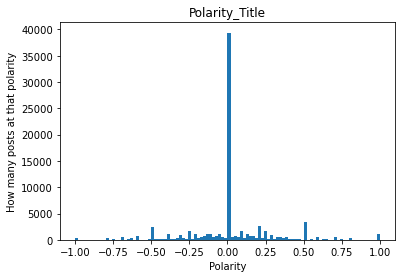

In [311]:
plt.hist(dfsub_samp['polarity'], bins=100);
plt.xlabel('Polarity')
plt.ylabel('How many posts at that polarity')
plt.title('Polarity_Title')

Interesting! Polarity is largely neutral in titles, and then otherwise apparently randomly distributed, save for the preponderance of 0.5 & -0.5 valences.

In [261]:
dfcom_samp['polarity'] = dfcom_samp['body'].apply(lambda x: TextBlob(x).sentiment.polarity)

,body,polarity,readinglevel
link_id,,,
t3_jc2x57,hug her when you first see her. if this was a ...,0.168875,143.7
t3_jrba4q,i'm fairly certain that he prefers to keep his...,0.130134,101.2
t3_kjxfk9,"hello /u/statisticianplus7133, your request ap...",0.042308,50.1
t3_kkuu3x,"100\n20. stop this, dude.\n22\nless stupid que...",0.148974,142.9
t3_ji1ak4,yeah but then you think you'd be broke off you...,0.141667,41.9


Text(0.5, 1.0, 'Polarity_Comments')

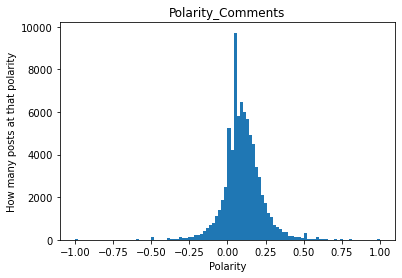

In [330]:
plt.hist(dfcom_samp['polarity'], bins=100);
plt.xlabel('Polarity')
plt.ylabel('How many posts at that polarity')
plt.title('Polarity_Comments')

Note the very different graph here - a normal distribution leaning on the positive polarities - this suggests to me that comments, in the aggregate, are largely encouraging (and that the community is, on the whole, actually on the kinder/more supportive side). 

And finally let's check out the reading level of each of these using the Flesch-Kincaid scale - info on that is in the final report: 

In [164]:
dfsub_samp['readinglevel'] = dfsub_samp['title'].apply(lambda x: textstat.flesch_kincaid_grade(x))
dfcom_samp['readinglevel'] = dfcom_samp['body'].apply(lambda x: textstat.flesch_kincaid_grade(x))

Text(0.5, 1.0, 'Reading Level_Title')

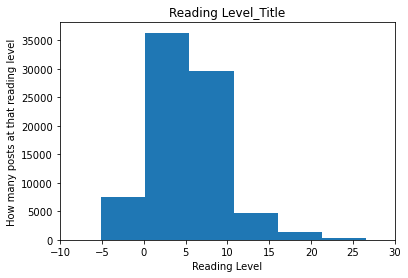

In [314]:
#Titles are pretty easy to read (though their brevity likely contributes to that).

plt.hist(dfsub_samp['readinglevel'], bins=100);
plt.xlabel('Reading Level')
plt.xlim(-10, 30)
plt.ylabel('How many posts at that reading level')
plt.title('Reading Level_Title')

Text(0.5, 1.0, 'Reading Level_Comments')

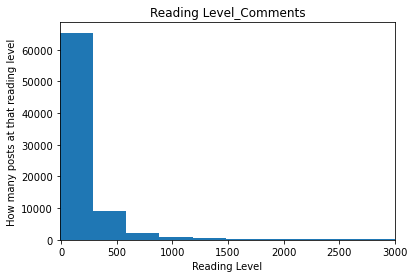

In [317]:
plt.hist(dfcom_samp['readinglevel'], bins=100);
plt.xlabel('Reading Level')
plt.xlim(-10, 3000) #reading level ostensibly goes into the tens of thousands - nuts
plt.ylabel('How many posts at that reading level')
plt.title('Reading Level_Comments')


#Comments have a very different reading level, likely because of the length of them (I clumped them all together).

In [175]:
#Next is processing in preparation for LDA (Latent Dirichlet Allocation) - An unsupervised learning method (Topic Model) 
#to help us uncover the hidden structure in the text.

#Making all to-be-vectorized text lowercase
processed_titles = dfsub_samp['title'].str.lower()
processed_comments = dfcom_samp['body'].str.lower()

#Removing anything that's not the alphabet (digits)
processed_titles = re.sub('[^a-zA-Z]', ' ', str(processed_titles))
processed_comments = re.sub('[^a-zA-Z]', ' ', str(processed_comments))

#Removing punctuation &c
processed_titles = re.sub(r'\s+', ' ', str(processed_titles))
processed_comments = re.sub(r'\s+', ' ', str(processed_comments))

#Converting tokens into sentences
all_titles = nltk.sent_tokenize(processed_titles)
all_comments = nltk.sent_tokenize(processed_comments)

#Converting sentences into words
all_title_words = [nltk.word_tokenize(sent) for sent in all_titles]
all_comment_words = [nltk.word_tokenize(sent) for sent in all_comments]

#Removing stopwords
for i in range(len(all_title_words)):
    all_title_words[i] = [w for w in all_title_words[i] if w not in stopwords.words('english')]
    
for i in range(len(all_comment_words)):
    all_comment_words[i] = [w for w in all_comment_words[i] if w not in stopwords.words('english')]

In [176]:
word2vec_title = Word2Vec(all_title_words, min_count=2)
word2vec_comments = Word2Vec(all_comment_words, min_count=2)

#How to fit/transform word2vec model to data (transformed_X from X_train, as is typical?)
#Am I actually doing that here with the above lines? The above are models - not usable in a Kmeans... what am I missing?

In [332]:
#For the titles - major thanks to Shashank Kapadia for giving the helpful tutorial & code on LDA, which I've borrowed here! 
#https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# Create Dictionary
id2word = corpora.Dictionary(all_title_words)

# Create Corpus
texts = all_title_words

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [335]:
# number of topics
num_topics = 10

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"best" + 0.029*"boyfriend" + 0.029*"f" + 0.029*"ex" + '
  '0.029*"pathetic" + 0.029*"stop" + 0.029*"wife" + 0.029*"guys" + '
  '0.029*"someone" + 0.029*"lives"'),
 (1,
  '0.029*"ex" + 0.029*"best" + 0.029*"f" + 0.029*"boyfriend" + 0.029*"title" + '
  '0.029*"face" + 0.029*"someone" + 0.029*"pathetic" + 0.029*"hurt" + '
  '0.029*"household"'),
 (2,
  '0.029*"best" + 0.029*"f" + 0.029*"ex" + 0.029*"boyfriend" + 0.029*"move" + '
  '0.029*"title" + 0.029*"breakup" + 0.029*"dtype" + 0.029*"wife" + '
  '0.029*"object"'),
 (3,
  '0.029*"best" + 0.029*"boyfriend" + 0.029*"f" + 0.029*"ex" + 0.029*"lives" + '
  '0.029*"guys" + 0.029*"move" + 0.029*"Length" + 0.029*"pathetic" + '
  '0.029*"anxiety"'),
 (4,
  '0.088*"best" + 0.065*"boyfriend" + 0.057*"ex" + 0.053*"f" + '
  '0.031*"girlfriend" + 0.029*"object" + 0.028*"lives" + 0.028*"wife" + '
  '0.027*"move" + 0.026*"hates"'),
 (5,
  '0.029*"best" + 0.029*"boyfriend" + 0.029*"f" + 0.029*"ex" + '
  '0.029*"pathetic" + 0.029*"title" +

In [346]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join(r"C:\Users\Robert Malka\Desktop\Springboard\ldavis_prepared_" +str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds')
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        # load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, r"C:\Users\Robert Malka\Desktop\Springboard\ldavis_prepared_" + str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.019127 -0.005566       1        1  97.954431
4     -0.013265 -0.007395       2        1   0.227368
9      0.004042  0.001636       3        1   0.227275
7      0.004052  0.001613       4        1   0.227275
6      0.004052  0.001613       5        1   0.227275
5      0.004048  0.001623       6        1   0.227275
3      0.004047  0.001625       7        1   0.227275
2      0.004054  0.001609       8        1   0.227275
1      0.004049  0.001622       9        1   0.227275
0      0.004049  0.001621      10        1   0.227275, topic_info=         Term      Freq     Total Category  logprob  loglift
4        best  3.000000  3.000000  Default  30.0000  30.0000
10          f  3.000000  3.000000  Default  29.0000  29.0000
9          ex  3.000000  3.000000  Default  28.0000  28.0000
5   boyfriend  2.000000  2.000000  Default  27.0000  27.0000
21    makeout  1.000000  1.000000  Default  26.0000  26.0000
..        ...       ...       ...      ...      ...      ...
21    makeout  0.002874  1.185434  Topic10  -3.5264   0.0647
4        best  0.002874  3.433914  Topic10  -3.5263  -0.9988
5   boyfriend  0.002874  2.700247  Topic10  -3.5263  -0.7585
10          f  0.002874  3.156854  Topic10  -3.5264  -0.9147
9          ex  0.002874  3.016987  Topic10  -3.5264  -0.8694

[363 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.851914      Length
1         1  1.014130        Name
2         1  0.952959     anxiety
3         1  1.007117         bes
4         1  0.873639        best
5         1  1.111010   boyfriend
6         1  0.977438     breakup
7         1  0.946589         bud
8         1  1.022051       dtype
9         1  0.994369          ex
10        1  0.950313           f
11        1  0.900282        face
12        1  0.851753     fucking
13        1  0.933851     getting
14        1  1.301104  girlfriend
15        1  0.937025        guys
16        1  1.049996       hates
17        1  0.965068   household
18        1  0.924808        hurt
19        1  1.103527       lives
20        1  1.000470        make
21        1  0.843573     makeout
22        1  1.087262        move
23        1  1.149621      object
24        1  1.021605    pathetic
25        1  0.963106      regret
26        1  1.009589       sleep
27        1  0.849266     someone
28        1  0.916395        stop
29        1  1.002235    terrible
30        1  1.008275       title
31        1  0.922091        told
32        1  0.969077         way
33        1  1.101967        wife, R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 10, 8, 7, 6, 4, 3, 2, 1])

In [353]:
#For the comments

id2word2 = corpora.Dictionary(all_comment_words)

texts2 = all_comment_words

corpus2 = [id2word2.doc2bow(text) for text in texts]

In [354]:
num_topics = 10

lda_model2 = gensim.models.LdaMulticore(corpus=corpus2,
                                       id2word=id2word2,
                                       num_topics=num_topics)
pprint(lda_model2.print_topics())
doc_lda2 = lda_model2[corpus2]

[(0,
  '0.016*"Length" + 0.016*"dtype" + 0.016*"bes" + 0.016*"Name" + '
  '0.016*"object" + 0.016*"stop" + 0.016*"nmaybe" + 0.016*"picnic" + '
  '0.016*"pe" + 0.016*"q"'),
 (1,
  '0.016*"dtype" + 0.016*"Name" + 0.016*"stop" + 0.016*"bes" + 0.016*"object" '
  '+ 0.016*"Length" + 0.016*"nmaybe" + 0.016*"picnic" + 0.016*"pe" + '
  '0.016*"q"'),
 (2,
  '0.016*"Length" + 0.016*"bes" + 0.016*"Name" + 0.016*"dtype" + '
  '0.016*"object" + 0.016*"stop" + 0.016*"nmaybe" + 0.016*"picnic" + '
  '0.016*"pe" + 0.016*"q"'),
 (3,
  '0.090*"stop" + 0.090*"object" + 0.090*"dtype" + 0.090*"bes" + 0.090*"Name" '
  '+ 0.090*"Length" + 0.008*"nmaybe" + 0.008*"picnic" + 0.008*"pe" + '
  '0.008*"q"'),
 (4,
  '0.016*"bes" + 0.016*"Name" + 0.016*"Length" + 0.016*"dtype" + '
  '0.016*"object" + 0.016*"stop" + 0.016*"nmaybe" + 0.016*"picnic" + '
  '0.016*"pe" + 0.016*"q"'),
 (5,
  '0.016*"Length" + 0.016*"Name" + 0.016*"dtype" + 0.016*"object" + '
  '0.016*"bes" + 0.016*"stop" + 0.016*"nmaybe" + 0.016*"picnic" +

In [355]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath2 = os.path.join(r"C:\Users\Robert Malka\Desktop\Springboard\2ldavis_prepared_" +str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared2 = pyLDAvis.gensim.prepare(lda_model2, corpus2, id2word2, mds='mmds')
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared2, f)
        # load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath2, 'rb') as f:
    LDAvis_prepared2 = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared2, r"C:\Users\Robert Malka\Desktop\Springboard\2ldavis_prepared_" + str(num_topics) +'.html')

LDAvis_prepared2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.103813  0.036179       1        1  87.142830
9     -0.011536 -0.004016       2        1   1.428574
8     -0.011535 -0.004018       3        1   1.428574
7     -0.011537 -0.004014       4        1   1.428574
6     -0.011533 -0.004024       5        1   1.428574
5     -0.011536 -0.004016       6        1   1.428574
4     -0.011534 -0.004021       7        1   1.428574
2     -0.011535 -0.004018       8        1   1.428574
1     -0.011534 -0.004021       9        1   1.428574
0     -0.011531 -0.004030      10        1   1.428574, topic_info=      Term      Freq     Total Category  logprob  loglift
0   Length  0.000000  0.000000  Default  30.0000  30.0000
1     Name  0.000000  0.000000  Default  29.0000  29.0000
6      bes  0.000000  0.000000  Default  28.0000  28.0000
13   dtype  0.000000  0.000000  Default  27.0000  27.0000
40  object  0.000000  0.000000  Default  26.0000  26.0000
..     ...       ...       ...      ...      ...      ...
13   dtype  0.001383  0.483861  Topic10  -4.1271  -1.6094
6      bes  0.001383  0.483859  Topic10  -4.1271  -1.6094
1     Name  0.001383  0.483858  Topic10  -4.1271  -1.6094
40  object  0.001383  0.483863  Topic10  -4.1271  -1.6094
51    stop  0.001383  0.483865  Topic10  -4.1271  -1.6094

[384 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 9, 8, 7, 6, 5, 3, 2, 1])

In [192]:
#with thanks to DJ Sarkar for these two functions, allowing the averaging of the corpus so that proper vectorization can
#happen.

def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                                     for tokenized_sentence in corpus]
    return np.array(features)

In [195]:
#Get document level embeddings for title
ft_doc_features_title = averaged_word_vectorizer(corpus=all_title_words, model=word2vec_title, num_features=100)
X_sub = pd.DataFrame(ft_doc_features_title)

C:\Users\Robert Malka\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [293]:
#Get document level embeddings for comments
ft_doc_features_comments = averaged_word_vectorizer(corpus=all_comment_words, model=word2vec_comments,
                                             num_features=100)

X_com = pd.DataFrame(ft_doc_features_comments)

#Ask DJ exactly what's going on here. 100 features, and how to fix it?

C:\Users\Robert Malka\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [ ]:
#In case you prefer TFIDF over Word2Vec

#vectorizer = TfidfVectorizer(tokenizer=None,
#               min_df=30, max_df=0.9, strip_accents='unicode', use_idf=1,
#               smooth_idf=1, sublinear_tf=1 )

#words = np.array(vectorizer.get_feature_names())


In [306]:
#Inertia = error of model (lower the inertia, the better the model) ((K-means, look up documentation))
#open up documentation for K-means
#inertia doesn't give you the cluster labels - check that to get the labels for the documents

def get_inertia(x_name, n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=47)
    model.fit(x_name.reshape(-1,1))
    inertia_new = model.inertia_
    return inertia_new

inertia_new = []
n_clusters = range(1,5)

ValueError: x and y must have same first dimension, but have shapes (4,) and (594,)

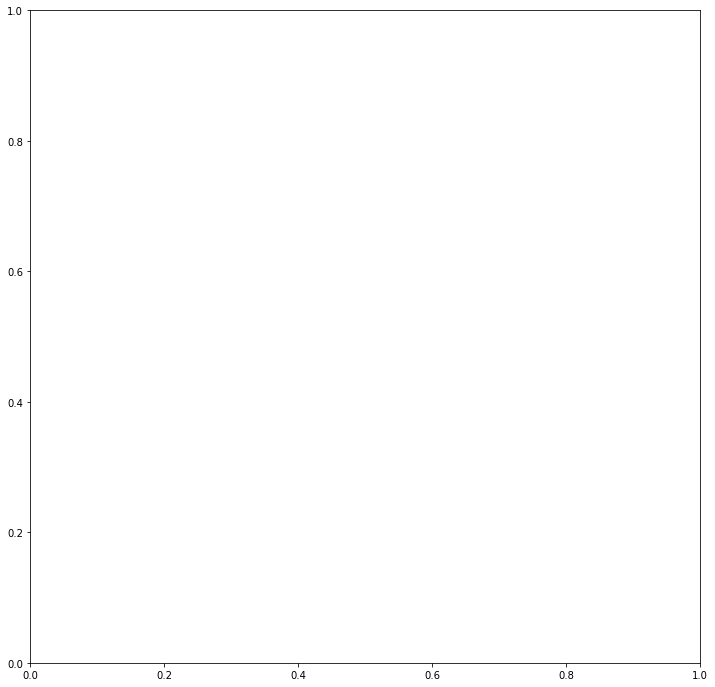

In [307]:
#Finding the elbow for x_title

x_sub_new = X_sub.to_numpy()

#x_sub_new = np.array(all_title_words) #attempted to see if this list would work out. It didn't. Shape of it
#was (1, 43), which makes even less sense than avging # of features to 100 thru above function.

for i in n_clusters:
    inertia_new.append(get_inertia(x_title, i))
    
plt.subplots(figsize=(12,12))
plt.plot(n_clusters, inertia)

plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.yticks(np.arange(0,20,20))

plt.show()


In [ ]:
#Finding the elbow for x_comments

x_comments = X_com.to_numpy()

for i in n_clusters:
    inertia.append(get_inertia(x_comments, i))
    
plt.subplots(figsize=(12,12))
plt.plot(n_clusters, inertia)

plt.xlabel('Number of Clusters K')
plt.ylabel('Inertia')
plt.yticks(np.arange(0,20,20))

plt.show()


In [ ]:
#Titles first:

ss = []

assignments = {}

X1 = X_sub.to_numpy()

# Make a variable called Krange, and assign it a list of range(2, 11)
Krange  = list(range(2, 11))

# We now want to iterate through this list to construct a plot showing SS for each K. Name the iterator variable K 
for K in ss:
    # Make a variable called model, and assign it the result of calling sklearn.cluster.KMeans, with n_clusters = K 
    model = sklearn.cluster.KMeans(n_clusters=K)
    assigned_cluster = model.fit_predict(X1)
    centers = model.cluster_centers_
    ss.append(np.sum((X1 - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster

In [ ]:
#Run the Kmeans model here.

kmeans_cluster = KMeans(n_clusters = 5, random_state=42) #.fit(word2vec_title) #Fit to avg to word vectors
#Change pivoted to dataframe
X_sub['kmeans_cluster'] = kmeans_cluster.fit_predict(X1)
X_sub.kmeans_cluster.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')

In [ ]:
#Filter based on cluster column (and look for e.g. k = 1, k=5, and so on)
# Kmeans [[1]] ==> look at comments & draw inferences.

In [ ]:
# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
model = sklearn.cluster.KMeans(n_clusters=3)
# Call a fit_predict() on X 
cluster_assignments = model.fit_predict(X1)


In [179]:
#Comments second:

ss = []

assignments = {}

X2 = X_com.to_numpy()

Krange  = list(range(2, 11))

#Constructing plot showing SS for each K.
for K in ss:
    model = sklearn.cluster.KMeans(n_clusters=K)
    assigned_cluster = model.fit_predict(X2)
    centers = model.cluster_centers_
    ss.append(np.sum((X2 - centers[assigned_cluster]) ** 2))
    assignments[str(K)] = assigned_cluster

NameError: name 'X_com' is not defined

In [180]:
kmeans_cluster = KMeans(n_clusters = 5, random_state=42)
X_com['kmeans_cluster'] = kmeans_cluster.fit_predict(X2)
X_com.kmeans_cluster.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')

NameError: name 'X2' is not defined

In [181]:
# Make a variable called model. We want n_clusters = 3 as parameter to sklearn.cluster.KMeans 
model2 = sklearn.cluster.KMeans(n_clusters=3)
# Call a fit_predict() on X 
cluster_assignments2 = model2.fit_predict(X2)


NameError: name 'X2' is not defined

1) Make sure the model as given works. DONE
3) Train GPT2 from scratch using comments from relationship_advice, and then give relationship_advice titles as the data for it to respond to. IN PROGRESS


Reddit:

- Use Pushshift.io to get more than 1,000 comments DONE
- Find an effective way to loop through both title & (top 10) comments. DONE
- Run it and get your dataset. DONE


GPT-2:
- Model as given: Figure out why it's not producing text from r/legaladvice (decoding issue?). DONE
- Run relationship_advice titles + comments (Full 1MM titles + 3MM comments), save the notebook, record and discuss the results. (You'll need to use Pickle to keep the model running, or run it straight from your GPU.) IN PROGRESS
   - This will mean knowing how to run Pickle.
- Set up a website using your trained model (quickly).

Steps in cleanup:
- Change Epoch time to datetime DONE
- Stopwords to split up all the text DONE
- Lowercase all the text (no need to expand contractions) DONE
- A separate dataframe we'll save and run through GPT-2 will have ONLY the titles and comments. DONE
- The fuller dataframe will go through an EDA. DONE

Steps in EDA:

- Do a wordcloud for the titles DONE
- Do a wordcloud for the comments DONE
   - Goal of the wordclouds is to get a sense of what kind of topics they discuss on relationship_advice (though we'll leave it to GPT-2 to figure out the deeper advice &c to give).
- Word Embedding through Word2Vec (vectorize words this way -- or through TFIDF as done with AITA) DONE
- K-means cluster to evaluate each observation and their groupings DONE
   - Find ideal clustering number
   - Run K-means & diagram
   - After clustering, see which comments & titles share commonalities.
- Sentiment Analysis DONE
- Text Reading level (Flesch-Kincaid) DONE

And that's it for EDA - a quick analysis to help us get to know our data. No need to try to grapple with it deeply, since it'll likely be hard to group it well.

FINAL STEPS:
- A powerpoint describing the final product - what you trained it on, what you found in your EDA, and sampling some of the results you get when you ask it a question.
- A document particularly describing what you've found in asking certain questions and the answers you get.

In [228]:
#to test and see if this id actually exists in the comments df, since so many NaNs exist in the comments after joining.
#(this is the first entry in the submissions dataframe)

dfcom[dfcom['link_id'] == "t3_llei6f"] 

#Sample code from previous project to find exact ID.
#df.loc[df.id=='2ft7yg','body'].to_list()


,body,id,link_id,created
755,"honestly, it sounds like he's messed this up t...",gnp3ha0,t3_llei6f,2021-02-17 06:14:25
1073,i think you have destroyed your own self-estee...,gnp1miq,t3_llei6f,2021-02-17 06:00:12
1167,i feel like i'm missing something here. is he ...,gnp0yxg,t3_llei6f,2021-02-17 05:55:22
1177,"guys think just about anything is attractive, ...",gnp0wn7,t3_llei6f,2021-02-17 05:54:54
1234,you had low self-esteem to begin with. he didn...,gnp0k3m,t3_llei6f,2021-02-17 05:52:21
1250,just because he likes redheads doesn't mean th...,gnp0g5r,t3_llei6f,2021-02-17 05:51:32


In [230]:
df_fin.loc[df_fin.index=='t3_llei6f', 'comment_body'].to_list()

['honestly, it sounds like he\'s messed this up too much for it to continue. if you\'re carrying his comment with you even after an apology, this really can\'t work as long as you hold onto it. so if you want it to work, you need to recognize that he\'s a moron with a fetish which isn\'t reflective of you who made the mistake of vocalizing his fetish like an idiot, and then you need to decide if you\'re really capable of forgiving him for it and finding your own self esteem again. he put both feet in his mouth and now you just have to decide if you still want to kiss him after he pulls them out and brushes his teeth. no wrong answers - if this relationship is dead there\'s no doubt that he\'s the one that killed it and maybe he\'ll learn to watch his mouth better next time.\n\nto be fair, he actually didn\'t say anything about you, he just said he likes red hair on people. i\'m sure there\'s some feature that you like in men that he doesn\'t have and i\'m also sure that it doesn\'t rea

In [ ]:
#Preparing the separate dataframes for GPT-2

dfsub_gpt2 = dfsub.drop(['created', 'id', 'post_body'], axis=1)
dfcom_gpt2 = dfcom.drop(['created', 'id', 'link_id'], axis=1)

In [ ]:
dfsub_gpt2['title'] = '<|startoftext|>[WP]' + dfsub['title'].astype(str) + '<|endoftext|>'

In [ ]:
#join both sub & com together into one column
#dfsub_gpt2['title'] = '<|startoftext|>[WP]' + dfsub['title'].astype(str)

In [ ]:
dfcom_gpt2['body'] = '<|startoftext|>[RESPONSE]' + dfcom['body'].astype(str) + '<|endoftext|>'

In [ ]:
dfsub_gpt2.to_csv('relationship_advice_titles.csv', header=None, index=False, sep=' ', mode='a')
dfcom_gpt2.to_csv('relationship_advice_comments.csv', header=None, index=False, sep=' ', mode='a')

#for .txt df.to_csv(r'c:\data\pandas.txt', header=None, index=None, sep=' ', mode='a')

In [ ]:
#dfsub['id'] = dfsub['id'].map(lambda x: x.lstrip('t3_'))
